# Test Variational Inference algorithms for Wold processes

In this notebook, we test the various variational inference (VI) algorithms implemented for the multivariate Wold process. Namely:

* `WoldModelVariational`: VI with parameters $\alpha$ and $\beta$
* `WoldModelVariationalFixedBeta`: VI with parameters $\alpha$ only ($\beta$ are fixed hyper-parameters)

---

Load extensions for debugging

In [1]:
%load_ext autoreload
%autoreload 2

%load_ext line_profiler

Import the libraries of interest for this notebook

In [31]:
from matplotlib import pyplot as plt
%matplotlib inline

import itertools
import torch
import numpy as np

import tsvar

---

## Generate small toy example dataset

Define model parameters

In [40]:
baseline = np.array([0.10, 0.10, 0.02])

# adjacency[i,j] = magnitude of influence from i to j
adjacency = np.array([
    [0.2, 0.2, 0  ],
    [0.2, 0.5, 0.2],
    [0  , 0.2, 0  ]
])

beta = np.array([0.3, 0.8, 0.1])
#beta = 1

end_time = 5e5

dim = len(baseline)

for i, j in itertools.product(range(dim), repeat=2):
    print(f"w({j:d} -> {i:d}) = {adjacency[j,i]:.2f}")

w(0 -> 0) = 0.20
w(1 -> 0) = 0.20
w(2 -> 0) = 0.00
w(0 -> 1) = 0.20
w(1 -> 1) = 0.50
w(2 -> 1) = 0.20
w(0 -> 2) = 0.00
w(1 -> 2) = 0.20
w(2 -> 2) = 0.00


Simulate a dataset

In [41]:
wold_sim = tsvar.simulate.GrangerBuscaSimulator(mu_rates=baseline, Alpha_ba=adjacency, Beta_b=beta * np.ones((dim,)))
events = wold_sim.simulate(end_time, seed=4243)
events = [torch.tensor(ev, dtype=torch.float) for ev in events]


print('Number of events per dimension:', list(map(len, events)))
print('Total number of events:', sum(map(len, events)))
print()
print(events[0])
print()
print(events[1])
print()
print(events[2])

Number of events per dimension: [97927, 148100, 32077]
Total number of events: 278104

tensor([9.8140e+00, 3.4728e+01, 3.7404e+01,  ..., 4.9996e+05, 4.9997e+05,
        4.9999e+05])

tensor([1.2944e+01, 1.3375e+01, 1.7024e+01,  ..., 4.9998e+05, 4.9999e+05,
        4.9999e+05])

tensor([3.1062e+01, 3.7435e+01, 4.0530e+01,  ..., 4.9997e+05, 4.9998e+05,
        4.9998e+05])


---

## Test Mean-Field VI with Fixed $\{\beta\}$s using `WoldModelVariationalFixedBeta`

Define the model object.

In [42]:
beta_ji_plus_one = np.repeat(beta[:,np.newaxis], dim, axis=1) + 1
beta_ji_plus_one = np.vstack((np.zeros(dim), beta_ji_plus_one))
beta_ji_plus_one

array([[0. , 0. , 0. ],
       [1.3, 1.3, 1.3],
       [1.8, 1.8, 1.8],
       [1.1, 1.1, 1.1]])

In [43]:
model_fixed_beta = tsvar.models.WoldModelVariationalFixedBeta(verbose=True)
model_fixed_beta.observe(events, beta=beta_ji_plus_one)

Set the hyper-parameters and fit the model.

In [87]:
as_pr = 1.0 * np.ones((dim + 1, dim))
ar_pr = 1.0 * np.ones((dim + 1, dim))

zc_pr = [1.0 * np.ones((len(events[i]), dim+1)) for i in range(dim)]

callback = tsvar.utils.callbacks.LearnerCallbackMLE(
    x0=(as_pr / ar_pr).flatten(), 
    print_every=10, 
    coeffs_true=np.hstack((baseline, adjacency.flatten())),
    acc_thresh=0.05, dim=dim)

model_fixed_beta.fit(as_pr=as_pr, ar_pr=ar_pr, zc_pr=zc_pr, max_iter=200, tol=1e-5, callback=callback)

iter:   200 | dx: +2.4973e-05 | loss: nan | dloss: +nan | time-per-iter: 4.75e-03 | acc: 1.00     

Explore the results.

In [92]:
alpha_hat_mode = np.round((model_fixed_beta._as_po >= 1) * (model_fixed_beta._as_po - 1) / model_fixed_beta._ar_po, 2)
alpha_hat_mean = np.round(model_fixed_beta._as_po / model_fixed_beta._ar_po, 2)

baseline_hat = alpha_hat_mean[0,:]
adjacency_hat = alpha_hat_mean[1:,:]

print('Baseline:')
print('---------')
print('Ground truth:')
print(baseline)
print('Estimated:')
print(baseline_hat)
print()

print('Adjacency:')
print('---------')
print('Ground truth:')
print(adjacency)
print('Estimated:')
print(adjacency_hat)
print()

Baseline:
---------
Ground truth:
[0.1  0.1  0.02]
Estimated:
[0. 0. 0.]

Adjacency:
---------
Ground truth:
[[0.2 0.2 0. ]
 [0.2 0.5 0.2]
 [0.  0.2 0. ]]
Estimated:
[[0.21 0.21 0.  ]
 [0.2  0.52 0.2 ]
 [0.01 0.21 0.  ]]



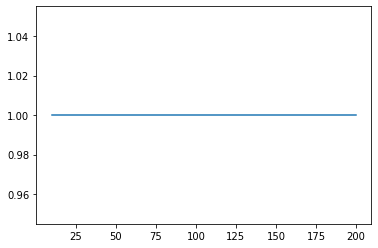

In [89]:
x_iter = callback.history['iter']
y_base = [tsvar.utils.metrics.relerr(np.array(coeffs[:3]), baseline) for coeffs in callback.history['coeffs']]

plt.plot(x_iter, y_base);

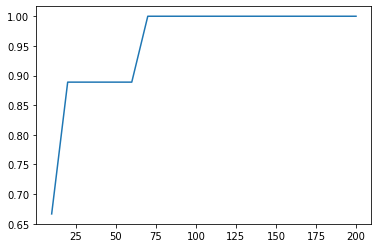

In [90]:
x_iter = callback.history['iter']
y_acc = [tsvar.utils.metrics.accuracy(adj_test=np.array(coeffs[-9:]), 
                                      adj_true=adjacency.flatten(), 
                                      threshold=0.02) 
         for coeffs in callback.history['coeffs']]

plt.plot(x_iter, y_acc);

---

## Test Mean-Field VI with Variable $\{\beta\}$s using `WoldModelVariational`

Create model object and set the data.

In [31]:
model = WoldModelVariational(verbose=True)
model.observe(events)

Define the parameters of the prior.

In [32]:
as_pr = 1.0 * np.ones((dim + 1, dim))
ar_pr = 1.0 * np.ones((dim + 1, dim))

bs_pr = 10.0 * np.ones((dim, dim))
br_pr = 10.0 * np.ones((dim, dim))

zc_pr = [1.0 * np.ones((len(events[i]), dim+1)) for i in range(dim)]

Fit the model.

In [34]:
model.fit(as_pr=as_pr, ar_pr=ar_pr, bs_pr=bs_pr, br_pr=br_pr, zc_pr=zc_pr, max_iter=1000, tol=1e-5)

-------------------------------------------------- 0
Alpha posterior mean:
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
Z[0] posterior probabilities
[[0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 ...
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]]
-------------------------------------------------- 1
Alpha posterior mean:
[[0.03 0.06 0.01 0.05]
 [0.11 0.17 0.03 0.14]
 [0.08 0.14 0.03 0.1 ]
 [0.21 0.37 0.07 0.31]
 [0.08 0.15 0.03 0.14]]
Z posterior probabilities
[[0.19994 0.20002 0.2     0.20003 0.20001]
 [0.49991 0.50009 0.      0.      0.     ]
 [0.50171 0.49829 0.      0.      0.     ]
 ...
 [0.24994 0.25003 0.25001 0.      0.25002]
 [0.33325 0.      0.      0.3334  0.33335]
 [1.      0.      0.      0.      0.     ]]
-------------------------------------------------- 2
Alpha posterior mean:
[[0.08 0.13 0.02 0.1 ]
 [0.2  0.3  0.05 0.25]
 [0.14 0.25 0.06 0.16]
 [0.33 0.63 0.1  0.53]
 [0.14 0.26 0.04 0.29]]
Z po

Z posterior probabilities
[[0.72966 0.08232 0.09057 0.03818 0.05927]
 [0.72966 0.08232 0.09057 0.03818 0.05927]
 [0.72966 0.08232 0.09057 0.03818 0.05927]
 ...
 [0.72966 0.08232 0.09057 0.03818 0.05927]
 [0.72966 0.08232 0.09057 0.03818 0.05927]
 [0.80222 0.09051 0.00012 0.04197 0.06517]]
-------------------------------------------------- 18
Alpha posterior mean:
[[0.13 0.21 0.04 0.16]
 [0.32 0.46 0.06 0.4 ]
 [0.22 0.44 0.12 0.22]
 [0.45 0.96 0.14 0.82]
 [0.19 0.41 0.05 0.64]]
Z posterior probabilities
[[0.73345 0.08138 0.08939 0.03757 0.0582 ]
 [0.73345 0.08138 0.08939 0.03757 0.0582 ]
 [0.73345 0.08138 0.08939 0.03757 0.0582 ]
 ...
 [0.73345 0.08138 0.08939 0.03757 0.0582 ]
 [0.73345 0.08138 0.08939 0.03757 0.0582 ]
 [0.73782 0.08187 0.08397 0.0378  0.05855]]
-------------------------------------------------- 19
Alpha posterior mean:
[[0.13 0.21 0.04 0.16]
 [0.32 0.47 0.07 0.4 ]
 [0.22 0.44 0.12 0.22]
 [0.45 0.96 0.14 0.82]
 [0.19 0.41 0.05 0.65]]
Z posterior probabilities
[[0.73691 

Z posterior probabilities
[[0.76828 0.07276 0.07848 0.03217 0.04832]
 [0.76828 0.07276 0.07848 0.03217 0.04832]
 [0.76828 0.07276 0.07848 0.03217 0.04832]
 ...
 [0.76828 0.07276 0.07848 0.03217 0.04832]
 [0.76828 0.07276 0.07848 0.03217 0.04832]
 [0.76828 0.07276 0.07848 0.03217 0.04832]]
-------------------------------------------------- 35
Alpha posterior mean:
[[0.13 0.22 0.04 0.17]
 [0.34 0.49 0.07 0.42]
 [0.22 0.48 0.14 0.22]
 [0.46 0.99 0.14 0.85]
 [0.19 0.43 0.05 0.73]]
Z posterior probabilities
[[0.76959 0.07242 0.07807 0.03197 0.04795]
 [0.76959 0.07242 0.07807 0.03197 0.04795]
 [0.76959 0.07242 0.07807 0.03197 0.04795]
 ...
 [0.76959 0.07242 0.07807 0.03197 0.04795]
 [0.76959 0.07242 0.07807 0.03197 0.04795]
 [0.76959 0.07242 0.07807 0.03197 0.04795]]
-------------------------------------------------- 36
Alpha posterior mean:
[[0.13 0.22 0.04 0.17]
 [0.34 0.49 0.07 0.43]
 [0.22 0.48 0.14 0.22]
 [0.46 0.99 0.14 0.85]
 [0.19 0.43 0.05 0.74]]
Z posterior probabilities
[[0.77083 

Z posterior probabilities
[[0.78448 0.06857 0.07352 0.02988 0.04355]
 [0.78448 0.06857 0.07352 0.02988 0.04355]
 [0.78448 0.06857 0.07352 0.02988 0.04355]
 ...
 [0.78448 0.06857 0.07352 0.02988 0.04355]
 [0.78448 0.06857 0.07352 0.02988 0.04355]
 [0.78448 0.06857 0.07352 0.02988 0.04355]]
-------------------------------------------------- 52
Alpha posterior mean:
[[0.14 0.22 0.04 0.17]
 [0.35 0.5  0.07 0.43]
 [0.23 0.5  0.15 0.22]
 [0.46 1.   0.14 0.86]
 [0.18 0.43 0.05 0.78]]
Z posterior probabilities
[[0.78516 0.06839 0.07331 0.02979 0.04335]
 [0.78516 0.06839 0.07331 0.02979 0.04335]
 [0.78516 0.06839 0.07331 0.02979 0.04335]
 ...
 [0.78516 0.06839 0.07331 0.02979 0.04335]
 [0.78516 0.06839 0.07331 0.02979 0.04335]
 [0.78516 0.06839 0.07331 0.02979 0.04335]]
-------------------------------------------------- 53
Alpha posterior mean:
[[0.14 0.22 0.04 0.17]
 [0.35 0.5  0.07 0.44]
 [0.23 0.5  0.15 0.22]
 [0.46 1.   0.14 0.87]
 [0.18 0.43 0.05 0.78]]
Z posterior probabilities
[[0.78581 

Z posterior probabilities
[[0.79384 0.06621 0.07052 0.02864 0.04079]
 [0.79384 0.06621 0.07052 0.02864 0.04079]
 [0.79384 0.06621 0.07052 0.02864 0.04079]
 ...
 [0.79384 0.06621 0.07052 0.02864 0.04079]
 [0.79384 0.06621 0.07052 0.02864 0.04079]
 [0.79384 0.06621 0.07052 0.02864 0.04079]]
-------------------------------------------------- 69
Alpha posterior mean:
[[0.14 0.22 0.04 0.17]
 [0.35 0.51 0.06 0.44]
 [0.23 0.51 0.15 0.22]
 [0.45 1.   0.14 0.87]
 [0.18 0.44 0.05 0.81]]
Z posterior probabilities
[[0.79428 0.0661  0.07037 0.02859 0.04067]
 [0.79428 0.0661  0.07037 0.02859 0.04067]
 [0.79428 0.0661  0.07037 0.02859 0.04067]
 ...
 [0.79428 0.0661  0.07037 0.02859 0.04067]
 [0.79428 0.0661  0.07037 0.02859 0.04067]
 [0.79428 0.0661  0.07037 0.02859 0.04067]]
-------------------------------------------------- 70
Alpha posterior mean:
[[0.14 0.22 0.04 0.17]
 [0.35 0.51 0.06 0.44]
 [0.23 0.51 0.15 0.22]
 [0.45 1.   0.14 0.87]
 [0.18 0.44 0.05 0.81]]
Z posterior probabilities
[[0.7947  

Z posterior probabilities
[[0.80009 0.06463 0.06836 0.02791 0.03902]
 [0.80009 0.06463 0.06836 0.02791 0.03902]
 [0.80009 0.06463 0.06836 0.02791 0.03902]
 ...
 [0.80009 0.06463 0.06836 0.02791 0.03902]
 [0.80009 0.06463 0.06836 0.02791 0.03902]
 [0.80009 0.06463 0.06836 0.02791 0.03902]]
-------------------------------------------------- 86
Alpha posterior mean:
[[0.14 0.23 0.04 0.18]
 [0.36 0.51 0.06 0.44]
 [0.23 0.52 0.16 0.22]
 [0.45 1.   0.13 0.87]
 [0.18 0.44 0.05 0.83]]
Z posterior probabilities
[[0.80039 0.06455 0.06825 0.02788 0.03893]
 [0.80039 0.06455 0.06825 0.02788 0.03893]
 [0.80039 0.06455 0.06825 0.02788 0.03893]
 ...
 [0.80039 0.06455 0.06825 0.02788 0.03893]
 [0.80039 0.06455 0.06825 0.02788 0.03893]
 [0.80039 0.06455 0.06825 0.02788 0.03893]]
-------------------------------------------------- 87
Alpha posterior mean:
[[0.14 0.23 0.04 0.18]
 [0.36 0.51 0.06 0.44]
 [0.23 0.52 0.16 0.22]
 [0.45 1.   0.13 0.87]
 [0.18 0.44 0.05 0.83]]
Z posterior probabilities
[[0.80068 

Z posterior probabilities
[[0.80444 0.06353 0.06684 0.02739 0.0378 ]
 [0.80444 0.06353 0.06684 0.02739 0.0378 ]
 [0.80444 0.06353 0.06684 0.02739 0.0378 ]
 ...
 [0.80444 0.06353 0.06684 0.02739 0.0378 ]
 [0.80444 0.06353 0.06684 0.02739 0.0378 ]
 [0.80444 0.06353 0.06684 0.02739 0.0378 ]]
-------------------------------------------------- 103
Alpha posterior mean:
[[0.14 0.23 0.04 0.18]
 [0.36 0.51 0.06 0.44]
 [0.23 0.53 0.16 0.22]
 [0.45 1.   0.13 0.87]
 [0.18 0.45 0.05 0.85]]
Z posterior probabilities
[[0.80466 0.06348 0.06676 0.02737 0.03774]
 [0.80466 0.06348 0.06676 0.02737 0.03774]
 [0.80466 0.06348 0.06676 0.02737 0.03774]
 ...
 [0.80466 0.06348 0.06676 0.02737 0.03774]
 [0.80466 0.06348 0.06676 0.02737 0.03774]
 [0.80466 0.06348 0.06676 0.02737 0.03774]]
-------------------------------------------------- 104
Alpha posterior mean:
[[0.14 0.23 0.04 0.18]
 [0.36 0.51 0.06 0.44]
 [0.23 0.53 0.17 0.22]
 [0.45 1.   0.13 0.87]
 [0.18 0.45 0.05 0.85]]
Z posterior probabilities
[[0.8048

Z posterior probabilities
[[0.80773 0.06275 0.06562 0.02697 0.03692]
 [0.80773 0.06275 0.06562 0.02697 0.03692]
 [0.80773 0.06275 0.06562 0.02697 0.03692]
 ...
 [0.80773 0.06275 0.06562 0.02697 0.03692]
 [0.80773 0.06275 0.06562 0.02697 0.03692]
 [0.80773 0.06275 0.06562 0.02697 0.03692]]
-------------------------------------------------- 120
Alpha posterior mean:
[[0.14 0.23 0.04 0.18]
 [0.36 0.52 0.06 0.44]
 [0.23 0.54 0.17 0.22]
 [0.44 1.   0.13 0.86]
 [0.18 0.45 0.05 0.87]]
Z posterior probabilities
[[0.8079  0.06271 0.06556 0.02694 0.03688]
 [0.8079  0.06271 0.06556 0.02694 0.03688]
 [0.8079  0.06271 0.06556 0.02694 0.03688]
 ...
 [0.8079  0.06271 0.06556 0.02694 0.03688]
 [0.8079  0.06271 0.06556 0.02694 0.03688]
 [0.8079  0.06271 0.06556 0.02694 0.03688]]
-------------------------------------------------- 121
Alpha posterior mean:
[[0.14 0.23 0.04 0.18]
 [0.36 0.52 0.06 0.44]
 [0.23 0.54 0.17 0.22]
 [0.44 1.   0.13 0.86]
 [0.18 0.45 0.05 0.87]]
Z posterior probabilities
[[0.8080

Z posterior probabilities
[[0.8103  0.06216 0.0647  0.02659 0.03625]
 [0.8103  0.06216 0.0647  0.02659 0.03625]
 [0.8103  0.06216 0.0647  0.02659 0.03625]
 ...
 [0.8103  0.06216 0.0647  0.02659 0.03625]
 [0.8103  0.06216 0.0647  0.02659 0.03625]
 [0.8103  0.06216 0.0647  0.02659 0.03625]]
-------------------------------------------------- 137
Alpha posterior mean:
[[0.14 0.23 0.04 0.18]
 [0.36 0.52 0.06 0.44]
 [0.23 0.54 0.18 0.22]
 [0.44 0.99 0.12 0.86]
 [0.18 0.45 0.05 0.88]]
Z posterior probabilities
[[0.81044 0.06213 0.06465 0.02657 0.03621]
 [0.81044 0.06213 0.06465 0.02657 0.03621]
 [0.81044 0.06213 0.06465 0.02657 0.03621]
 ...
 [0.81044 0.06213 0.06465 0.02657 0.03621]
 [0.81044 0.06213 0.06465 0.02657 0.03621]
 [0.81044 0.06213 0.06465 0.02657 0.03621]]
-------------------------------------------------- 138
Alpha posterior mean:
[[0.14 0.23 0.04 0.18]
 [0.36 0.52 0.06 0.44]
 [0.23 0.54 0.18 0.22]
 [0.44 0.99 0.12 0.86]
 [0.18 0.45 0.05 0.88]]
Z posterior probabilities
[[0.8105

Z posterior probabilities
[[0.81236 0.06173 0.06397 0.02624 0.03569]
 [0.81236 0.06173 0.06397 0.02624 0.03569]
 [0.81236 0.06173 0.06397 0.02624 0.03569]
 ...
 [0.81236 0.06173 0.06397 0.02624 0.03569]
 [0.81236 0.06173 0.06397 0.02624 0.03569]
 [0.81236 0.06173 0.06397 0.02624 0.03569]]
-------------------------------------------------- 154
Alpha posterior mean:
[[0.14 0.23 0.04 0.18]
 [0.37 0.52 0.06 0.44]
 [0.23 0.55 0.18 0.22]
 [0.43 0.99 0.12 0.85]
 [0.17 0.45 0.04 0.9 ]]
Z posterior probabilities
[[0.81247 0.06171 0.06394 0.02622 0.03566]
 [0.81247 0.06171 0.06394 0.02622 0.03566]
 [0.81247 0.06171 0.06394 0.02622 0.03566]
 ...
 [0.81247 0.06171 0.06394 0.02622 0.03566]
 [0.81247 0.06171 0.06394 0.02622 0.03566]
 [0.81247 0.06171 0.06394 0.02622 0.03566]]
-------------------------------------------------- 155
Alpha posterior mean:
[[0.14 0.23 0.04 0.18]
 [0.37 0.52 0.06 0.44]
 [0.23 0.55 0.18 0.22]
 [0.43 0.99 0.12 0.85]
 [0.17 0.45 0.04 0.9 ]]
Z posterior probabilities
[[0.8125

Z posterior probabilities
[[0.81406 0.06143 0.0634  0.02591 0.0352 ]
 [0.81406 0.06143 0.0634  0.02591 0.0352 ]
 [0.81406 0.06143 0.0634  0.02591 0.0352 ]
 ...
 [0.81406 0.06143 0.0634  0.02591 0.0352 ]
 [0.81406 0.06143 0.0634  0.02591 0.0352 ]
 [0.81406 0.06143 0.0634  0.02591 0.0352 ]]
-------------------------------------------------- 171
Alpha posterior mean:
[[0.14 0.23 0.04 0.18]
 [0.37 0.52 0.06 0.44]
 [0.23 0.55 0.19 0.22]
 [0.43 0.98 0.12 0.85]
 [0.17 0.45 0.04 0.91]]
Z posterior probabilities
[[0.81415 0.06141 0.06337 0.02589 0.03517]
 [0.81415 0.06141 0.06337 0.02589 0.03517]
 [0.81415 0.06141 0.06337 0.02589 0.03517]
 ...
 [0.81415 0.06141 0.06337 0.02589 0.03517]
 [0.81415 0.06141 0.06337 0.02589 0.03517]
 [0.81415 0.06141 0.06337 0.02589 0.03517]]
-------------------------------------------------- 172
Alpha posterior mean:
[[0.14 0.23 0.04 0.18]
 [0.37 0.52 0.06 0.44]
 [0.23 0.55 0.19 0.22]
 [0.43 0.98 0.12 0.85]
 [0.17 0.45 0.04 0.91]]
Z posterior probabilities
[[0.8142

Z posterior probabilities
[[0.8155  0.06123 0.0629  0.0256  0.03478]
 [0.8155  0.06123 0.0629  0.0256  0.03478]
 [0.8155  0.06123 0.0629  0.0256  0.03478]
 ...
 [0.8155  0.06123 0.0629  0.0256  0.03478]
 [0.8155  0.06123 0.0629  0.0256  0.03478]
 [0.8155  0.06123 0.0629  0.0256  0.03478]]
-------------------------------------------------- 188
Alpha posterior mean:
[[0.14 0.23 0.04 0.18]
 [0.37 0.52 0.05 0.44]
 [0.23 0.56 0.19 0.22]
 [0.42 0.98 0.11 0.84]
 [0.17 0.45 0.04 0.92]]
Z posterior probabilities
[[0.81558 0.06122 0.06287 0.02558 0.03475]
 [0.81558 0.06122 0.06287 0.02558 0.03475]
 [0.81558 0.06122 0.06287 0.02558 0.03475]
 ...
 [0.81558 0.06122 0.06287 0.02558 0.03475]
 [0.81558 0.06122 0.06287 0.02558 0.03475]
 [0.81558 0.06122 0.06287 0.02558 0.03475]]
-------------------------------------------------- 189
Alpha posterior mean:
[[0.14 0.23 0.04 0.18]
 [0.37 0.52 0.05 0.44]
 [0.23 0.56 0.19 0.22]
 [0.42 0.98 0.11 0.84]
 [0.17 0.45 0.04 0.93]]
Z posterior probabilities
[[0.8156

Z posterior probabilities
[[0.81679 0.06108 0.06244 0.0253  0.0344 ]
 [0.81679 0.06108 0.06244 0.0253  0.0344 ]
 [0.81679 0.06108 0.06244 0.0253  0.0344 ]
 ...
 [0.81679 0.06108 0.06244 0.0253  0.0344 ]
 [0.81679 0.06108 0.06244 0.0253  0.0344 ]
 [0.81679 0.06108 0.06244 0.0253  0.0344 ]]
-------------------------------------------------- 205
Alpha posterior mean:
[[0.14 0.23 0.04 0.18]
 [0.37 0.52 0.05 0.44]
 [0.23 0.56 0.19 0.22]
 [0.41 0.97 0.11 0.84]
 [0.17 0.45 0.04 0.94]]
Z posterior probabilities
[[0.81686 0.06108 0.06241 0.02528 0.03438]
 [0.81686 0.06108 0.06241 0.02528 0.03438]
 [0.81686 0.06108 0.06241 0.02528 0.03438]
 ...
 [0.81686 0.06108 0.06241 0.02528 0.03438]
 [0.81686 0.06108 0.06241 0.02528 0.03438]
 [0.81686 0.06108 0.06241 0.02528 0.03438]]
-------------------------------------------------- 206
Alpha posterior mean:
[[0.14 0.23 0.04 0.18]
 [0.37 0.52 0.05 0.44]
 [0.23 0.56 0.2  0.22]
 [0.41 0.97 0.11 0.84]
 [0.17 0.45 0.04 0.94]]
Z posterior probabilities
[[0.8169

Z posterior probabilities
[[0.81796 0.06097 0.06202 0.025   0.03405]
 [0.81796 0.06097 0.06202 0.025   0.03405]
 [0.81796 0.06097 0.06202 0.025   0.03405]
 ...
 [0.81796 0.06097 0.06202 0.025   0.03405]
 [0.81796 0.06097 0.06202 0.025   0.03405]
 [0.81796 0.06097 0.06202 0.025   0.03405]]
-------------------------------------------------- 222
Alpha posterior mean:
[[0.14 0.23 0.04 0.18]
 [0.37 0.52 0.05 0.44]
 [0.23 0.56 0.2  0.22]
 [0.41 0.97 0.11 0.83]
 [0.17 0.45 0.04 0.95]]
Z posterior probabilities
[[0.81802 0.06097 0.062   0.02498 0.03403]
 [0.81802 0.06097 0.062   0.02498 0.03403]
 [0.81802 0.06097 0.062   0.02498 0.03403]
 ...
 [0.81802 0.06097 0.062   0.02498 0.03403]
 [0.81802 0.06097 0.062   0.02498 0.03403]
 [0.81802 0.06097 0.062   0.02498 0.03403]]
-------------------------------------------------- 223
Alpha posterior mean:
[[0.14 0.23 0.04 0.18]
 [0.37 0.52 0.05 0.44]
 [0.23 0.56 0.2  0.22]
 [0.41 0.97 0.11 0.83]
 [0.17 0.45 0.04 0.95]]
Z posterior probabilities
[[0.8180

Z posterior probabilities
[[0.81904 0.06089 0.06165 0.0247  0.03372]
 [0.81904 0.06089 0.06165 0.0247  0.03372]
 [0.81904 0.06089 0.06165 0.0247  0.03372]
 ...
 [0.81904 0.06089 0.06165 0.0247  0.03372]
 [0.81904 0.06089 0.06165 0.0247  0.03372]
 [0.81904 0.06089 0.06165 0.0247  0.03372]]
-------------------------------------------------- 239
Alpha posterior mean:
[[0.14 0.23 0.04 0.18]
 [0.37 0.52 0.05 0.44]
 [0.23 0.57 0.2  0.22]
 [0.4  0.96 0.1  0.83]
 [0.17 0.45 0.04 0.96]]
Z posterior probabilities
[[0.8191  0.06088 0.06163 0.02469 0.0337 ]
 [0.8191  0.06088 0.06163 0.02469 0.0337 ]
 [0.8191  0.06088 0.06163 0.02469 0.0337 ]
 ...
 [0.8191  0.06088 0.06163 0.02469 0.0337 ]
 [0.8191  0.06088 0.06163 0.02469 0.0337 ]
 [0.8191  0.06088 0.06163 0.02469 0.0337 ]]
-------------------------------------------------- 240
Alpha posterior mean:
[[0.14 0.23 0.04 0.18]
 [0.37 0.52 0.05 0.44]
 [0.23 0.57 0.2  0.22]
 [0.4  0.96 0.1  0.83]
 [0.17 0.45 0.04 0.96]]
Z posterior probabilities
[[0.8191

Z posterior probabilities
[[0.82004 0.06083 0.06131 0.02441 0.03341]
 [0.82004 0.06083 0.06131 0.02441 0.03341]
 [0.82004 0.06083 0.06131 0.02441 0.03341]
 ...
 [0.82004 0.06083 0.06131 0.02441 0.03341]
 [0.82004 0.06083 0.06131 0.02441 0.03341]
 [0.82004 0.06083 0.06131 0.02441 0.03341]]
-------------------------------------------------- 256
Alpha posterior mean:
[[0.14 0.23 0.04 0.18]
 [0.37 0.52 0.05 0.44]
 [0.23 0.57 0.21 0.22]
 [0.4  0.95 0.1  0.82]
 [0.16 0.45 0.04 0.97]]
Z posterior probabilities
[[0.82009 0.06082 0.06129 0.0244  0.03339]
 [0.82009 0.06082 0.06129 0.0244  0.03339]
 [0.82009 0.06082 0.06129 0.0244  0.03339]
 ...
 [0.82009 0.06082 0.06129 0.0244  0.03339]
 [0.82009 0.06082 0.06129 0.0244  0.03339]
 [0.82009 0.06082 0.06129 0.0244  0.03339]]
-------------------------------------------------- 257
Alpha posterior mean:
[[0.14 0.23 0.04 0.18]
 [0.37 0.52 0.05 0.44]
 [0.23 0.57 0.21 0.22]
 [0.4  0.95 0.1  0.82]
 [0.16 0.45 0.04 0.97]]
Z posterior probabilities
[[0.8201

Z posterior probabilities
[[0.82097 0.06078 0.06101 0.02413 0.03311]
 [0.82097 0.06078 0.06101 0.02413 0.03311]
 [0.82097 0.06078 0.06101 0.02413 0.03311]
 ...
 [0.82097 0.06078 0.06101 0.02413 0.03311]
 [0.82097 0.06078 0.06101 0.02413 0.03311]
 [0.82097 0.06078 0.06101 0.02413 0.03311]]
-------------------------------------------------- 273
Alpha posterior mean:
[[0.14 0.23 0.04 0.18]
 [0.37 0.52 0.05 0.44]
 [0.23 0.57 0.21 0.22]
 [0.39 0.95 0.1  0.82]
 [0.16 0.45 0.03 0.97]]
Z posterior probabilities
[[0.82102 0.06078 0.061   0.02411 0.03309]
 [0.82102 0.06078 0.061   0.02411 0.03309]
 [0.82102 0.06078 0.061   0.02411 0.03309]
 ...
 [0.82102 0.06078 0.061   0.02411 0.03309]
 [0.82102 0.06078 0.061   0.02411 0.03309]
 [0.82102 0.06078 0.061   0.02411 0.03309]]
-------------------------------------------------- 274
Alpha posterior mean:
[[0.14 0.23 0.04 0.18]
 [0.37 0.52 0.05 0.44]
 [0.23 0.57 0.21 0.22]
 [0.39 0.95 0.1  0.82]
 [0.16 0.45 0.03 0.97]]
Z posterior probabilities
[[0.8210

Z posterior probabilities
[[0.82185 0.06075 0.06074 0.02384 0.03282]
 [0.82185 0.06075 0.06074 0.02384 0.03282]
 [0.82185 0.06075 0.06074 0.02384 0.03282]
 ...
 [0.82185 0.06075 0.06074 0.02384 0.03282]
 [0.82185 0.06075 0.06074 0.02384 0.03282]
 [0.82185 0.06075 0.06074 0.02384 0.03282]]
-------------------------------------------------- 290
Alpha posterior mean:
[[0.14 0.23 0.04 0.18]
 [0.37 0.52 0.05 0.44]
 [0.23 0.58 0.21 0.22]
 [0.38 0.94 0.09 0.81]
 [0.16 0.45 0.03 0.98]]
Z posterior probabilities
[[0.8219  0.06075 0.06073 0.02382 0.0328 ]
 [0.8219  0.06075 0.06073 0.02382 0.0328 ]
 [0.8219  0.06075 0.06073 0.02382 0.0328 ]
 ...
 [0.8219  0.06075 0.06073 0.02382 0.0328 ]
 [0.8219  0.06075 0.06073 0.02382 0.0328 ]
 [0.8219  0.06075 0.06073 0.02382 0.0328 ]]
-------------------------------------------------- 291
Alpha posterior mean:
[[0.14 0.23 0.04 0.18]
 [0.37 0.52 0.05 0.44]
 [0.23 0.58 0.21 0.22]
 [0.38 0.94 0.09 0.81]
 [0.16 0.45 0.03 0.98]]
Z posterior probabilities
[[0.8219

Z posterior probabilities
[[0.82269 0.06073 0.0605  0.02356 0.03253]
 [0.82269 0.06073 0.0605  0.02356 0.03253]
 [0.82269 0.06073 0.0605  0.02356 0.03253]
 ...
 [0.82269 0.06073 0.0605  0.02356 0.03253]
 [0.82269 0.06073 0.0605  0.02356 0.03253]
 [0.82269 0.06073 0.0605  0.02356 0.03253]]
-------------------------------------------------- 307
Alpha posterior mean:
[[0.14 0.23 0.04 0.18]
 [0.37 0.52 0.05 0.44]
 [0.22 0.58 0.22 0.22]
 [0.38 0.94 0.09 0.81]
 [0.16 0.45 0.03 0.99]]
Z posterior probabilities
[[0.82274 0.06073 0.06048 0.02354 0.03251]
 [0.82274 0.06073 0.06048 0.02354 0.03251]
 [0.82274 0.06073 0.06048 0.02354 0.03251]
 ...
 [0.82274 0.06073 0.06048 0.02354 0.03251]
 [0.82274 0.06073 0.06048 0.02354 0.03251]
 [0.82274 0.06073 0.06048 0.02354 0.03251]]
-------------------------------------------------- 308
Alpha posterior mean:
[[0.14 0.23 0.04 0.18]
 [0.37 0.52 0.05 0.44]
 [0.22 0.58 0.22 0.22]
 [0.38 0.94 0.09 0.81]
 [0.16 0.45 0.03 0.99]]
Z posterior probabilities
[[0.8227

Z posterior probabilities
[[0.82349 0.06072 0.06027 0.02327 0.03225]
 [0.82349 0.06072 0.06027 0.02327 0.03225]
 [0.82349 0.06072 0.06027 0.02327 0.03225]
 ...
 [0.82349 0.06072 0.06027 0.02327 0.03225]
 [0.82349 0.06072 0.06027 0.02327 0.03225]
 [0.82349 0.06072 0.06027 0.02327 0.03225]]
-------------------------------------------------- 324
Alpha posterior mean:
[[0.14 0.23 0.04 0.18]
 [0.37 0.51 0.04 0.44]
 [0.22 0.58 0.22 0.22]
 [0.37 0.93 0.09 0.8 ]
 [0.16 0.45 0.03 1.  ]]
Z posterior probabilities
[[0.82354 0.06072 0.06026 0.02326 0.03223]
 [0.82354 0.06072 0.06026 0.02326 0.03223]
 [0.82354 0.06072 0.06026 0.02326 0.03223]
 ...
 [0.82354 0.06072 0.06026 0.02326 0.03223]
 [0.82354 0.06072 0.06026 0.02326 0.03223]
 [0.82354 0.06072 0.06026 0.02326 0.03223]]
-------------------------------------------------- 325
Alpha posterior mean:
[[0.14 0.23 0.04 0.18]
 [0.37 0.51 0.04 0.44]
 [0.22 0.58 0.22 0.22]
 [0.37 0.93 0.09 0.8 ]
 [0.16 0.45 0.03 1.  ]]
Z posterior probabilities
[[0.8235

Z posterior probabilities
[[0.82426 0.06072 0.06007 0.02299 0.03196]
 [0.82426 0.06072 0.06007 0.02299 0.03196]
 [0.82426 0.06072 0.06007 0.02299 0.03196]
 ...
 [0.82426 0.06072 0.06007 0.02299 0.03196]
 [0.82426 0.06072 0.06007 0.02299 0.03196]
 [0.82426 0.06072 0.06007 0.02299 0.03196]]
-------------------------------------------------- 341
Alpha posterior mean:
[[0.14 0.23 0.04 0.18]
 [0.37 0.51 0.04 0.43]
 [0.22 0.58 0.22 0.22]
 [0.37 0.92 0.09 0.8 ]
 [0.16 0.45 0.03 1.01]]
Z posterior probabilities
[[0.82431 0.06072 0.06005 0.02298 0.03194]
 [0.82431 0.06072 0.06005 0.02298 0.03194]
 [0.82431 0.06072 0.06005 0.02298 0.03194]
 ...
 [0.82431 0.06072 0.06005 0.02298 0.03194]
 [0.82431 0.06072 0.06005 0.02298 0.03194]
 [0.82431 0.06072 0.06005 0.02298 0.03194]]
-------------------------------------------------- 342
Alpha posterior mean:
[[0.14 0.23 0.04 0.18]
 [0.37 0.51 0.04 0.43]
 [0.22 0.58 0.22 0.21]
 [0.37 0.92 0.09 0.8 ]
 [0.16 0.45 0.03 1.01]]
Z posterior probabilities
[[0.8243

Z posterior probabilities
[[0.82501 0.06073 0.05987 0.02271 0.03168]
 [0.82501 0.06073 0.05987 0.02271 0.03168]
 [0.82501 0.06073 0.05987 0.02271 0.03168]
 ...
 [0.82501 0.06073 0.05987 0.02271 0.03168]
 [0.82501 0.06073 0.05987 0.02271 0.03168]
 [0.82501 0.06073 0.05987 0.02271 0.03168]]
-------------------------------------------------- 358
Alpha posterior mean:
[[0.14 0.23 0.04 0.18]
 [0.37 0.51 0.04 0.43]
 [0.22 0.59 0.23 0.21]
 [0.36 0.92 0.08 0.79]
 [0.15 0.45 0.03 1.02]]
Z posterior probabilities
[[0.82505 0.06073 0.05986 0.0227  0.03166]
 [0.82505 0.06073 0.05986 0.0227  0.03166]
 [0.82505 0.06073 0.05986 0.0227  0.03166]
 ...
 [0.82505 0.06073 0.05986 0.0227  0.03166]
 [0.82505 0.06073 0.05986 0.0227  0.03166]
 [0.82505 0.06073 0.05986 0.0227  0.03166]]
-------------------------------------------------- 359
Alpha posterior mean:
[[0.14 0.23 0.04 0.18]
 [0.37 0.51 0.04 0.43]
 [0.22 0.59 0.23 0.21]
 [0.36 0.92 0.08 0.79]
 [0.15 0.45 0.03 1.02]]
Z posterior probabilities
[[0.8251

Z posterior probabilities
[[0.82574 0.06074 0.0597  0.02244 0.03139]
 [0.82574 0.06074 0.0597  0.02244 0.03139]
 [0.82574 0.06074 0.0597  0.02244 0.03139]
 ...
 [0.82574 0.06074 0.0597  0.02244 0.03139]
 [0.82574 0.06074 0.0597  0.02244 0.03139]
 [0.82574 0.06074 0.0597  0.02244 0.03139]]
-------------------------------------------------- 375
Alpha posterior mean:
[[0.14 0.23 0.04 0.18]
 [0.37 0.51 0.04 0.43]
 [0.22 0.59 0.23 0.21]
 [0.36 0.91 0.08 0.79]
 [0.15 0.45 0.03 1.02]]
Z posterior probabilities
[[0.82578 0.06074 0.05969 0.02242 0.03138]
 [0.82578 0.06074 0.05969 0.02242 0.03138]
 [0.82578 0.06074 0.05969 0.02242 0.03138]
 ...
 [0.82578 0.06074 0.05969 0.02242 0.03138]
 [0.82578 0.06074 0.05969 0.02242 0.03138]
 [0.82578 0.06074 0.05969 0.02242 0.03138]]
-------------------------------------------------- 376
Alpha posterior mean:
[[0.14 0.23 0.04 0.18]
 [0.37 0.51 0.04 0.43]
 [0.22 0.59 0.23 0.21]
 [0.36 0.91 0.08 0.79]
 [0.15 0.45 0.03 1.02]]
Z posterior probabilities
[[0.8258

Z posterior probabilities
[[0.82644 0.06075 0.05952 0.02216 0.03111]
 [0.82644 0.06075 0.05952 0.02216 0.03111]
 [0.82644 0.06075 0.05952 0.02216 0.03111]
 ...
 [0.82644 0.06075 0.05952 0.02216 0.03111]
 [0.82644 0.06075 0.05952 0.02216 0.03111]
 [0.82644 0.06075 0.05952 0.02216 0.03111]]
-------------------------------------------------- 392
Alpha posterior mean:
[[0.14 0.23 0.04 0.18]
 [0.37 0.51 0.04 0.43]
 [0.22 0.59 0.23 0.21]
 [0.35 0.91 0.08 0.78]
 [0.15 0.44 0.03 1.03]]
Z posterior probabilities
[[0.82649 0.06075 0.05951 0.02215 0.0311 ]
 [0.82649 0.06075 0.05951 0.02215 0.0311 ]
 [0.82649 0.06075 0.05951 0.02215 0.0311 ]
 ...
 [0.82649 0.06075 0.05951 0.02215 0.0311 ]
 [0.82649 0.06075 0.05951 0.02215 0.0311 ]
 [0.82649 0.06075 0.05951 0.02215 0.0311 ]]
-------------------------------------------------- 393
Alpha posterior mean:
[[0.14 0.23 0.04 0.18]
 [0.37 0.51 0.04 0.43]
 [0.22 0.59 0.23 0.21]
 [0.35 0.91 0.08 0.78]
 [0.15 0.44 0.03 1.03]]
Z posterior probabilities
[[0.8265

Z posterior probabilities
[[0.82714 0.06077 0.05936 0.02189 0.03084]
 [0.82714 0.06077 0.05936 0.02189 0.03084]
 [0.82714 0.06077 0.05936 0.02189 0.03084]
 ...
 [0.82714 0.06077 0.05936 0.02189 0.03084]
 [0.82714 0.06077 0.05936 0.02189 0.03084]
 [0.82714 0.06077 0.05936 0.02189 0.03084]]
-------------------------------------------------- 409
Alpha posterior mean:
[[0.14 0.23 0.04 0.18]
 [0.37 0.51 0.04 0.43]
 [0.22 0.59 0.24 0.21]
 [0.35 0.9  0.08 0.78]
 [0.15 0.44 0.02 1.04]]
Z posterior probabilities
[[0.82718 0.06077 0.05935 0.02188 0.03082]
 [0.82718 0.06077 0.05935 0.02188 0.03082]
 [0.82718 0.06077 0.05935 0.02188 0.03082]
 ...
 [0.82718 0.06077 0.05935 0.02188 0.03082]
 [0.82718 0.06077 0.05935 0.02188 0.03082]
 [0.82718 0.06077 0.05935 0.02188 0.03082]]
-------------------------------------------------- 410
Alpha posterior mean:
[[0.14 0.23 0.04 0.18]
 [0.37 0.51 0.04 0.43]
 [0.22 0.59 0.24 0.21]
 [0.35 0.9  0.08 0.78]
 [0.15 0.44 0.02 1.04]]
Z posterior probabilities
[[0.8272

Z posterior probabilities
[[0.82781 0.06079 0.0592  0.02162 0.03057]
 [0.82781 0.06079 0.0592  0.02162 0.03057]
 [0.82781 0.06079 0.0592  0.02162 0.03057]
 ...
 [0.82781 0.06079 0.0592  0.02162 0.03057]
 [0.82781 0.06079 0.0592  0.02162 0.03057]
 [0.82781 0.06079 0.0592  0.02162 0.03057]]
-------------------------------------------------- 426
Alpha posterior mean:
[[0.14 0.23 0.04 0.18]
 [0.37 0.51 0.04 0.43]
 [0.22 0.6  0.24 0.21]
 [0.34 0.89 0.07 0.77]
 [0.15 0.44 0.02 1.04]]
Z posterior probabilities
[[0.82785 0.06079 0.05919 0.02161 0.03055]
 [0.82785 0.06079 0.05919 0.02161 0.03055]
 [0.82785 0.06079 0.05919 0.02161 0.03055]
 ...
 [0.82785 0.06079 0.05919 0.02161 0.03055]
 [0.82785 0.06079 0.05919 0.02161 0.03055]
 [0.82785 0.06079 0.05919 0.02161 0.03055]]
-------------------------------------------------- 427
Alpha posterior mean:
[[0.14 0.23 0.04 0.18]
 [0.37 0.51 0.04 0.43]
 [0.22 0.6  0.24 0.21]
 [0.34 0.89 0.07 0.77]
 [0.15 0.44 0.02 1.04]]
Z posterior probabilities
[[0.8278

KeyboardInterrupt: 

In [ ]:
alpha_hat_mean = np.round(model._as_po / model._ar_po, 2)

baseline_hat = alpha_hat_mean[0,:]
print('Baseline:')
print('---------')
print('Ground truth:')
print(baseline)
print('Estimated:')
print(baseline_hat)
print()

adjacency_hat = alpha_hat_mean[1:,:]
print('Adjacency:')
print('---------')
print('Ground truth:')
print(adjacency)
print('Estimated:')
print(adjacency_hat)
print()

beta_hat = np.round(model._br_po / (model._bs_po - 1), 2) - 1
print('Beta:')
print('-----')
print('Ground truth:')
print(beta * np.ones((dim, dim)))
print('Estimated:')
print(beta_hat)